
M5 FORECASTING - CONFORMAL PREDICTION & UNCERTAINTY QUANTIFICATION

1/6 Caricamento dati...
Cluster data: (30490, 21)
Difficulty distribution:
difficulty
Medium    18316
Hard      10317
Easy       1857
Name: count, dtype: int64

Hier FAST forecasts: (30490, 28)

2/6 Preparazione train/test actuals...
Train actuals: (30490, 1914)
Test actuals: (30490, 29)

3/6 Calcolo residui OOF per calibrazione conformal...
Calibration residuals shape: (30490, 56)

4/6 Calcolo quantili conformal per confidence levels...

Quantili conformal per cluster:
  Cluster 0: n=  353, Q80=5.00, Q90=7.00, Q95=11.00
  Cluster 1: n=12908, Q80=2.00, Q90=3.00, Q95=4.00
  Cluster 2: n= 4074, Q80=6.00, Q90=8.00, Q95=12.00
  Cluster 3: n= 6623, Q80=5.00, Q90=7.00, Q95=10.00
  Cluster 4: n= 6532, Q80=1.00, Q90=2.00, Q95=3.00

5/6 Applicazione intervalli conformal al test set...

6/6 Valutazione coverage e sharpness...

--- Confidence Level: 80% ---
  Target Coverage:  80.00%
  Actual Coverage:  94.04%
  Avg Interval Wid

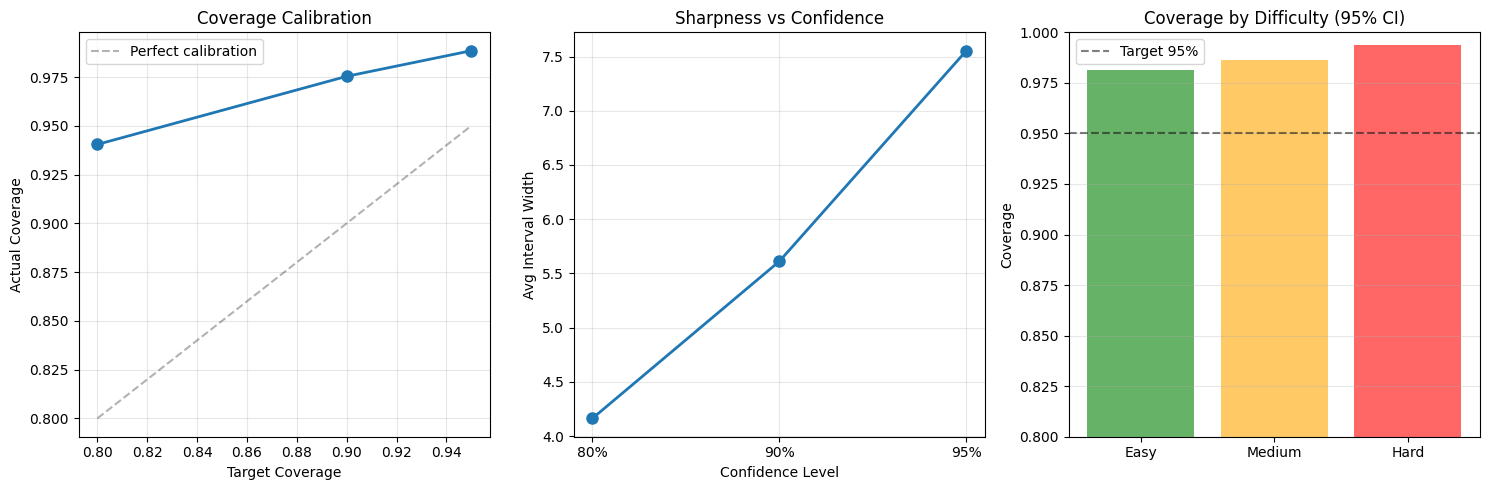

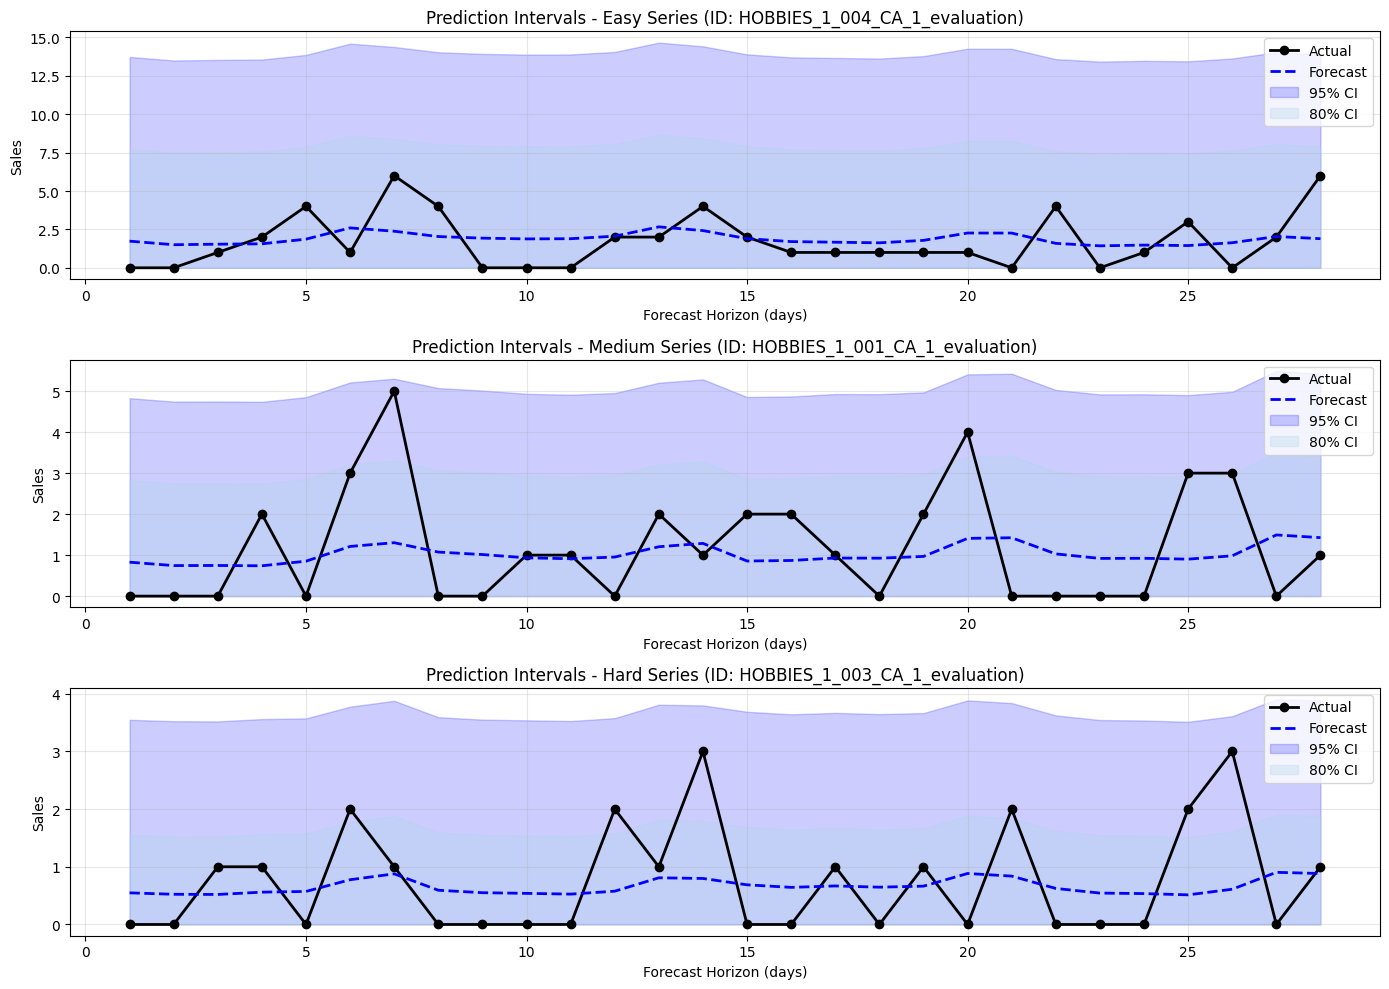

In [3]:
"""
Conformal Prediction for Uncertainty Quantification
"""

import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

print("\n" + "="*80)
print("M5 FORECASTING - CONFORMAL PREDICTION & UNCERTAINTY QUANTIFICATION")
print("="*80 + "\n")

# ============================================================================
# SETUP & OUTPUT DIRECTORY
# ============================================================================

DATA_PATH = Path("../data/raw")
RESULTS_PATH = Path("../data/hier_fast_results")
PREDICTABILITY_PATH = Path("../data/predictability_results")
OUTPUT_DIR = Path("../data/conformal_results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================================
# 1. CARICAMENTO DATI
# ============================================================================

print("1/6 Caricamento dati...")

sales = pd.read_csv(DATA_PATH / "sales_train_evaluation.csv")
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

cluster_df = pd.read_csv(PREDICTABILITY_PATH / "serie_cluster_difficulty.csv")
print(f"Cluster data: {cluster_df.shape}")
print(f"Difficulty distribution:")
print(cluster_df['difficulty'].value_counts())

hier_forecasts = pd.read_pickle(RESULTS_PATH / "hier_fast_forecasts.pkl")
print(f"\nHier FAST forecasts: {hier_forecasts.shape}")

# ============================================================================
# 2. PREPARAZIONE TRAIN/TEST ACTUALS
# ============================================================================

print("\n2/6 Preparazione train/test actuals...")

train_days = 1913
test_days = 28

# Training actuals (giorni 1-1913)
train_cols = [f'd_{i}' for i in range(1, train_days + 1)]
train_actuals = sales[['id'] + train_cols].copy()
train_actuals.columns = ['id'] + [f'F{i}' for i in range(1, train_days + 1)]

# Test actuals (giorni 1914-1941)
test_cols = [f'd_{i}' for i in range(train_days + 1, train_days + test_days + 1)]
test_actuals = sales[['id'] + test_cols].copy()
test_actuals.columns = ['id'] + [f'F{i}' for i in range(1, test_days + 1)]

print(f"Train actuals: {train_actuals.shape}")
print(f"Test actuals: {test_actuals.shape}")

# ============================================================================
# 3. CALCOLO RESIDUI OOF (Out-Of-Fold)
# ============================================================================

print("\n3/6 Calcolo residui OOF per calibrazione conformal...")

calibration_days = 56  
calibration_start = train_days - calibration_days - test_days + 1
calibration_end = train_days - test_days

# Actuals per calibrazione (giorni che precedono il test set)
calib_cols = [f'd_{i}' for i in range(calibration_start, calibration_end + 1)]
calib_actuals = sales[['id'] + calib_cols].copy()

# Predizioni naive per calibrazione (shift di 28 giorni = seasonal naive)
calib_pred_cols = [f'd_{i}' for i in range(calibration_start - 28, calibration_end - 28 + 1)]
calib_preds = sales[['id'] + calib_pred_cols].copy()
calib_preds.columns = calib_actuals.columns

# Residui calibrazione
residuals_calib = calib_actuals.iloc[:, 1:].values - calib_preds.iloc[:, 1:].values
print(f"Calibration residuals shape: {residuals_calib.shape}")

# ============================================================================
# 4. CONFORMAL PREDICTION - QUANTILI RESIDUALI
# ============================================================================

print("\n4/6 Calcolo quantili conformal per confidence levels...")

# Merge con cluster info
calib_df = calib_actuals[['id']].merge(
    cluster_df[['id', 'cluster', 'difficulty']], 
    on='id', 
    how='left'
)

# Confidence levels
alphas = [0.20, 0.10, 0.05]  
confidence_levels = [1 - alpha for alpha in alphas]

# Calcola quantili PER CLUSTER
print("\nQuantili conformal per cluster:")

quantiles_by_cluster = {}

for cluster_id in sorted(calib_df['cluster'].unique()):
    cluster_mask = calib_df['cluster'] == cluster_id
    cluster_residuals = residuals_calib[cluster_mask].flatten()
    
    quantiles = {}
    for alpha in alphas:
        # Conformal quantile: (n+1) * (1-alpha/2) / n
        q_upper = np.quantile(np.abs(cluster_residuals), 1 - alpha/2)
        quantiles[1 - alpha] = q_upper
    
    quantiles_by_cluster[cluster_id] = quantiles
    
    print(f"  Cluster {cluster_id}: n={cluster_mask.sum():5d}, "
          f"Q80={quantiles[0.80]:.2f}, Q90={quantiles[0.90]:.2f}, Q95={quantiles[0.95]:.2f}")

# ============================================================================
# 5. APPLICAZIONE INTERVALLI AL TEST SET
# ============================================================================

print("\n5/6 Applicazione intervalli conformal al test set...")

# Merge forecasts con cluster
hier_forecasts_full = hier_forecasts.reset_index().rename(columns={'index': 'id'})
hier_forecasts_full = hier_forecasts_full.merge(
    cluster_df[['id', 'cluster', 'difficulty']],
    on='id',
    how='left'
)

# Predizioni test
pred_cols = [f'F{i}' for i in range(1, test_days + 1)]
predictions = hier_forecasts_full[pred_cols].values

# Actuals test
actuals = test_actuals[pred_cols].values

# Calcola intervalli per ogni serie
intervals = {}

for conf_level in confidence_levels:
    lower_bounds = np.zeros_like(predictions)
    upper_bounds = np.zeros_like(predictions)
    
    for idx, cluster_id in enumerate(hier_forecasts_full['cluster']):
        if pd.isna(cluster_id):
            # Default se cluster mancante
            quantile = np.quantile(np.abs(residuals_calib.flatten()), 1 - (1 - conf_level)/2)
        else:
            quantile = quantiles_by_cluster[int(cluster_id)][conf_level]
        
        lower_bounds[idx] = predictions[idx] - quantile
        upper_bounds[idx] = predictions[idx] + quantile
    
    # Clip lower bound a 0 (sales non negative)
    lower_bounds = np.clip(lower_bounds, 0, None)
    
    intervals[conf_level] = {
        'lower': lower_bounds,
        'upper': upper_bounds
    }

# ============================================================================
# 6. VALUTAZIONE COVERAGE & SHARPNESS
# ============================================================================

print("\n6/6 Valutazione coverage e sharpness...")

results = []

for conf_level in confidence_levels:
    lower = intervals[conf_level]['lower']
    upper = intervals[conf_level]['upper']
    
    # Coverage: % di actuals dentro intervallo
    in_interval = (actuals >= lower) & (actuals <= upper)
    coverage = in_interval.mean()
    
    # Sharpness: larghezza media intervallo
    interval_width = (upper - lower).mean()
    
    # Coverage per difficulty
    coverage_by_diff = {}
    for diff in ['Easy', 'Medium', 'Hard']:
        mask = hier_forecasts_full['difficulty'] == diff
        if mask.sum() > 0:
            coverage_diff = in_interval[mask].mean()
            width_diff = (upper[mask] - lower[mask]).mean()
            coverage_by_diff[diff] = {
                'coverage': coverage_diff,
                'width': width_diff
            }
    
    results.append({
        'confidence_level': conf_level,
        'target_coverage': conf_level,
        'actual_coverage': coverage,
        'interval_width': interval_width,
        'coverage_by_difficulty': coverage_by_diff
    })
    
    print(f"\n--- Confidence Level: {conf_level:.0%} ---")
    print(f"  Target Coverage:  {conf_level:.2%}")
    print(f"  Actual Coverage:  {coverage:.2%}")
    print(f"  Avg Interval Width: {interval_width:.2f}")
    print(f"  Coverage by difficulty:")
    for diff, metrics in coverage_by_diff.items():
        print(f"    {diff:8s}: {metrics['coverage']:.2%} (width={metrics['width']:.2f})")

# ============================================================================
# 7. VISUALIZZAZIONI
# ============================================================================

print("\nGenerazione visualizzazioni...")

# Plot 1: Coverage vs Target
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Coverage calibration plot
ax = axes[0]
target_cov = [r['target_coverage'] for r in results]
actual_cov = [r['actual_coverage'] for r in results]
ax.plot(target_cov, actual_cov, 'o-', linewidth=2, markersize=8)
ax.plot([0.8, 0.95], [0.8, 0.95], 'k--', alpha=0.3, label='Perfect calibration')
ax.set_xlabel('Target Coverage')
ax.set_ylabel('Actual Coverage')
ax.set_title('Coverage Calibration')
ax.legend()
ax.grid(alpha=0.3)

# Interval width vs confidence
ax = axes[1]
widths = [r['interval_width'] for r in results]
ax.plot([f"{int(c*100)}%" for c in target_cov], widths, 'o-', linewidth=2, markersize=8)
ax.set_xlabel('Confidence Level')
ax.set_ylabel('Avg Interval Width')
ax.set_title('Sharpness vs Confidence')
ax.grid(alpha=0.3)

# Coverage by difficulty (95% level)
ax = axes[2]
r_95 = [r for r in results if r['confidence_level'] == 0.95][0]
difficulties = ['Easy', 'Medium', 'Hard']
coverages = [r_95['coverage_by_difficulty'][d]['coverage'] for d in difficulties]
colors = ['green', 'orange', 'red']
bars = ax.bar(difficulties, coverages, color=colors, alpha=0.6)
ax.axhline(0.95, color='k', linestyle='--', alpha=0.5, label='Target 95%')
ax.set_ylabel('Coverage')
ax.set_title('Coverage by Difficulty (95% CI)')
ax.set_ylim([0.8, 1.0])
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'conformal_evaluation.png', dpi=150, bbox_inches='tight')
print(f"✓ {OUTPUT_DIR}/conformal_evaluation.png")

# Plot 2: Sample series with prediction intervals
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for idx, diff in enumerate(['Easy', 'Medium', 'Hard']):
    # Seleziona serie esempio
    sample_idx = hier_forecasts_full[hier_forecasts_full['difficulty'] == diff].index[0]
    
    ax = axes[idx]
    
    # Actual
    ax.plot(range(1, 29), actuals[sample_idx], 'ko-', label='Actual', linewidth=2)
    
    # Prediction
    ax.plot(range(1, 29), predictions[sample_idx], 'b--', label='Forecast', linewidth=2)
    
    # 95% interval
    lower_95 = intervals[0.95]['lower'][sample_idx]
    upper_95 = intervals[0.95]['upper'][sample_idx]
    ax.fill_between(range(1, 29), lower_95, upper_95, alpha=0.2, color='blue', label='95% CI')
    
    # 80% interval
    lower_80 = intervals[0.80]['lower'][sample_idx]
    upper_80 = intervals[0.80]['upper'][sample_idx]
    ax.fill_between(range(1, 29), lower_80, upper_80, alpha=0.3, color='lightblue', label='80% CI')
    
    ax.set_xlabel('Forecast Horizon (days)')
    ax.set_ylabel('Sales')
    ax.set_title(f'Prediction Intervals - {diff} Series (ID: {hier_forecasts_full.iloc[sample_idx]["id"]})')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'conformal_intervals_examples.png', dpi=150, bbox_inches='tight')
print(f"✓ {OUTPUT_DIR}/conformal_intervals_examples.png")

# ============================================================================
# 8. SALVATAGGIO RISULTATI
# ============================================================================

print("\nSalvataggio risultati...")

# Salva intervalli
intervals_df = hier_forecasts_full[['id', 'cluster', 'difficulty']].copy()

for conf_level in confidence_levels:
    for h in range(1, test_days + 1):
        intervals_df[f'F{h}_pred'] = predictions[:, h-1]
        intervals_df[f'F{h}_lower_{int(conf_level*100)}'] = intervals[conf_level]['lower'][:, h-1]
        intervals_df[f'F{h}_upper_{int(conf_level*100)}'] = intervals[conf_level]['upper'][:, h-1]

intervals_df.to_csv(OUTPUT_DIR / 'conformal_prediction_intervals.csv', index=False)
print(f"✓ {OUTPUT_DIR}/conformal_prediction_intervals.csv ({intervals_df.shape})")

# Salva summary
with open(OUTPUT_DIR / 'conformal_summary.pkl', 'wb') as f:
    pickle.dump({
        'results': results,
        'quantiles_by_cluster': quantiles_by_cluster,
        'confidence_levels': confidence_levels
    }, f)
print(f"✓ {OUTPUT_DIR}/conformal_summary.pkl")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*80)
print("SUMMARY - CONFORMAL PREDICTION")
print("="*80)

print(f"\nCalibration set: {calibration_days} giorni")
print(f"Test set: {test_days} giorni")
print(f"Serie totali: {len(hier_forecasts_full)}")

print("\n--- Coverage Performance ---")
for r in results:
    gap = r['actual_coverage'] - r['target_coverage']
    status = "✓" if abs(gap) < 0.05 else "⚠"
    print(f"{status} {r['confidence_level']:.0%} CI: "
          f"Target={r['target_coverage']:.2%}, Actual={r['actual_coverage']:.2%}, "
          f"Gap={gap:+.2%}, Width={r['interval_width']:.2f}")

print("\nIntervalli più stretti per serie Easy, più larghi per Hard")
print("→ Adaptive uncertainty quantification basata su forecastability")

print("\n✓ CONFORMAL PREDICTION COMPLETATA")
print("="*80 + "\n")
